
# Shapefile transformations

## 1. Import modules

In [1]:
import sys
print(f'python     {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')

import pandas as pd
print(f'pandas     {pd.__version__}')

import geopandas as gpd
print(f'geopandas  {gpd.__version__}')

import matplotlib.pyplot as plt
print(f'matplotlib {sys.modules["matplotlib"].__version__}')

from shapely.geometry import Polygon, MultiPolygon
print(f'shapely    {sys.modules["shapely"].__version__}')

python     3.6.6
pandas     0.23.4
geopandas  0.3.0
matplotlib 2.2.2
shapely    1.6.4.post1


## 2. Transformation functions

### 2.1 Transform to csv

In [2]:
def to_csv(gdf, column, filename, geometry='geometry'):
    df = pd.DataFrame()
    for name in gdf[column].unique():
        p = gdf.loc[gdf[column] == name, 'geometry'].values[0]  # polygon
        if isinstance(p, Polygon):
            p = MultiPolygon([p]) # transform Polygon to MultiPolygon
        for i in range(len(p)):
            xcoord = p[i].exterior.coords.xy[0] # xcoord
            ycoord = p[i].exterior.coords.xy[1] # ycoord
            part = i + 1 # polygon number in multipolygon
            order = range(1, len(xcoord)+1) # order of polygon coordinates
            area = pd.DataFrame({'name': name, 'part': part, 'order': order, 'xcoord': xcoord, 'ycoord': ycoord})
            df = df.append(area, ignore_index=True)
    df.sort_values(by=['name', 'part', 'order'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df.to_csv(filename, index=False)
    print(f'{df.shape[0]} coordinates saved to file {filename}')

### 2.2 Transform to shapefile

In [3]:
def to_shp(df, shapefile, column='name', part='part', order='order', xcoord='xcoord', ycoord='ycoord'):
    
    """
    Function to save a DataFrame (from a csv file) with geospacial data to a shapefile.
    
    df        : the DataFrame to save to a shapefile
    shapefile : name of the shapefile to create (use extension .shp)
    column    : the name of the DataFrame column that contains the area names
    part      : the name of the DataFrame column that contains the order number of a polygon (within a multipolygon)
    order     : the name of the DataFrame column that contains the order number of the coordinates within a polygon
    xcoord    : the name of the DataFrame column that contains the x coordinate
    ycoord    : the name of the DataFrame column that contains the x coordinate
    
    example:
    
    to_shp(df, 'provincie.shp', column='prov_naam', xcoord='x', ycoord='y')
    """
    
    gdf = gpd.GeoDataFrame(columns=['name', 'geometry']) # empty GeoDataFrame
    
    for name in df[column].unique():
        rows = df.loc[df[column] == name].sort_values(by=[part, order]) # select rows by area name and sort
        parts = max(rows[part]) # number of polygons (parts) for selected area
        if parts == 1: # generate polygon
            polygon = Polygon(zip(rows[xcoord], rows[ycoord]))
            gdf = gdf.append({'name': name, 'geometry': polygon}, ignore_index=True)
        else: # generate multipolygon
            polygon_list = list()
            for num in range(1, parts+1):
                polygon_rows = rows[rows[part] == num].sort_values(by=order)
                polygon = Polygon(zip(polygon_rows[xcoord], polygon_rows[ycoord]))
                polygon_list.append(polygon)
            multipolygon = MultiPolygon(polygon_list)
            #row = pd.DataFrame({'name': name, 'geometry': multipolygon})
            gdf = gdf.append({'name': name, 'geometry': multipolygon}, ignore_index=True)
            
    gdf.reset_index(drop=True, inplace=True)
    gdf.to_file(shapefile)
    
    print(f'{gdf.shape[0]} polygons saved to {shapefile}')

# 3. From shapefile to csv

### 3.1 Read shapefile

In [4]:
shapefile = '../shapefiles/imergis/2018-Imergis_provinciegrenzen_kustlijn-shp/2018-Imergis_provinciegrenzen_kustlijn.shp'
gdf = gpd.read_file(shapefile)

### 3.2 Inspect shapefile

In [5]:
# Info
gdf.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
id            12 non-null int64
provincien    12 non-null object
geometry      12 non-null object
dtypes: int64(1), object(2)
memory usage: 1.4 KB


In [6]:
# Sample
gdf.sample(n=3)

,id,provincien,geometry
5,6,Drenthe,"POLYGON ((223906.541 555883.385, 223861.932 55..."
3,4,Zeeland,(POLYGON ((48116.21645152492 419985.8556412539...
11,12,Noord-Brabant,"(POLYGON ((122802.846 383738.555, 122804.31 38..."


In [7]:
# Set column name contrain the area names
column = 'provincien'

            name  polygons
0      Flevoland        23
1  Noord-Holland        12
2      Friesland        11
3        Zeeland        10
8  Noord-Brabant         9
4      Groningen         5
5     Overijssel         4
6   Zuid-Holland         3
7     Gelderland         2



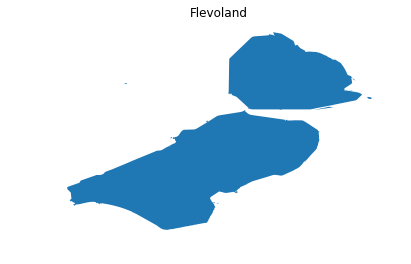

In [8]:
# MultiPolygons
df = pd.DataFrame()
for row in gdf.iterrows():
    value = row[1]
    if isinstance(value.geometry, MultiPolygon):
        df = df.append({'name': value[column], 'polygons': len(value.geometry)}, ignore_index=True)
        df = pd.DataFrame({'name': df.name,
                           'polygons': df.polygons.astype('int')
                          }
                         ).sort_values(by=['polygons', 'name'], ascending=[False, True])
if df.shape[0] == 0:
    print('No multipolygons found.')
else:
    print(df)
    print()
    f, ax = plt.subplots(1)
    ax = gdf.loc[gdf[column] == df.iloc[0, 0]].plot(ax=ax)
    ax.set_title(df.iloc[0, 0])
    plt.axis('off')
    plt.show()

### 3.3 Save csv

In [9]:
filename = '../output/csv/provincie.csv'
to_csv(gdf, column, filename)

146856 coordinates saved to file ../output/csv/provincie.csv


# 4. From csv to shapefile

## 4.1 Read csv

In [10]:
df = pd.read_csv(filename)

## 4.2 Inspect csv

In [11]:
# Info
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146856 entries, 0 to 146855
Data columns (total 5 columns):
name      146856 non-null object
part      146856 non-null int64
order     146856 non-null int64
xcoord    146856 non-null float64
ycoord    146856 non-null float64
dtypes: float64(2), int64(2), object(1)
memory usage: 13.8 MB


In [12]:
# Sample
df.sample(n=7)

,name,part,order,xcoord,ycoord
33069,Gelderland,1,8774,225125.776,473222.970
48109,Groningen,1,2489,251480.428,564982.721
115729,Utrecht,1,3882,127392.627,478023.275
63181,Limburg,1,7919,196529.160,312117.875
138863,Zuid-Holland,1,1027,103348.989,470033.326
122605,Utrecht,1,10758,160837.667,463836.712
102344,Overijssel,1,9279,228193.970,515762.630


In [13]:
# MultiPolygons
df[['name',
    'part']].groupby(by='name').part.max().to_frame().reset_index().query('part > 1').sort_values(by=['part',
                                                                                                      'name'],ascending=[False,
                                                                                                                         True])

,name,part
1,Flevoland,23
7,Noord-Holland,12
2,Friesland,11
10,Zeeland,10
6,Noord-Brabant,9
4,Groningen,5
8,Overijssel,4
11,Zuid-Holland,3
3,Gelderland,2


### 4.3 Save shapefile

In [14]:
filename = '../output/shapefile/provincie.shp'
to_shp(df, filename)

12 polygons saved to ../output/shapefile/provincie.shp


# 5. Test shapefile

In [15]:
# Read shapefile
test = gpd.read_file(filename)

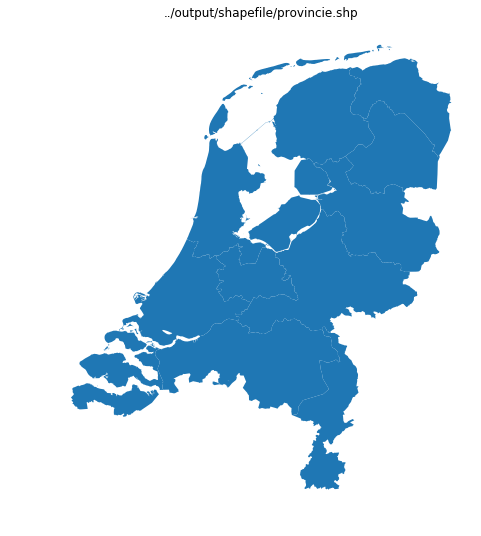

In [16]:
# Plot shapefile
f, ax = plt.subplots(1, figsize=(7.5, 9))
ax = test.plot(ax=ax)
ax.set_title(filename)
plt.axis('off')
plt.show()